In [85]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

import pickle

In [88]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath('utilities_and_data')
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility

In [2]:
import pystan

In [3]:
with open("data/drowning.txt") as f:
    lines = f.read().splitlines()
    lines = [l.split() for l in lines]

In [52]:
years = np.array([int(l[0]) for l in lines])
victims = np.array([int(l[1]) for l in lines])
N = len(years)
xpred = 2016    # Predict for 2016

In [36]:
years

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013])

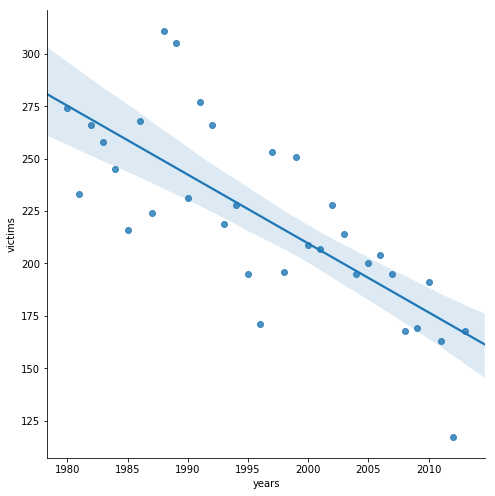

In [5]:
data =pd.DataFrame.from_items([('years',years), ('victims', victims)])
sns.pairplot(data, x_vars=['years'], y_vars='victims', size=7, kind='reg')

In [6]:
# Gaussian linear model with adjustable priors
drowning_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
 }
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}
"""

In [7]:
data = dict(
    N = N,
    x = years,
    y = victims,
    xpred = xpred,
                             # degree per 10 years
)

In [9]:
sm = pystan.StanModel(model_code=drowning_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f0e86229606a6afeeb9deac4462804e NOW.


In [10]:
import pickle
with open('drowning_model.pkl', 'wb') as f:
    pickle.dump(sm, f)


## Question 1.1
What can you say about the trend in the number of people drown per year? Plot the histogram of the slope of the linear model.

In [8]:
import pickle
sm = pickle.load(open('drowning_model.pkl', 'rb'))

fit = sm.sampling(data=data, iter=1000, chains=4)

If you look at the inference for Stan model you can see that the number of people drown per year is decreasing in general.

In [25]:
6776.9 - 3.28 * 2016

164.42000000000007

In [13]:
fit

Inference for Stan model: anon_model_3f0e86229606a6afeeb9deac4462804e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       6776.9   40.79 997.57 4829.4 6087.0 6789.2 7427.3 8760.2    598   1.01
beta         -3.28    0.02    0.5  -4.28  -3.61  -3.29  -2.94  -2.31    598   1.01
sigma        29.82    0.15   3.91  23.11   27.1  29.45  32.32   38.0    707    1.0
mu[0]       275.15    0.35   9.59  256.2 268.77  274.9 281.57 293.84    745   1.01
mu[1]       271.87    0.33   9.17 253.93 265.69 271.61 278.01 289.85    763   1.01
mu[2]       268.58    0.31   8.76 251.53 262.65  268.3 274.52 285.88    784   1.01
mu[3]        265.3    0.29   8.35 248.95 259.67 264.99 270.87 281.89    808   1.01
mu[4]       262.02    0.27   7.96 246.41 256.61 261.85  267.3 277.89    838   1.01
mu[5]       258.73    0.26   7.57 243.88 253.54  258.6 263.73 273.

In [21]:
samples = fit.extract(permuted=True)
samples

OrderedDict([('alpha',
              array([ 7329.59735806,  8861.98300373,  7303.31289173, ...,  5031.17648885,
                      6447.29283821,  6570.23654026])),
             ('beta',
              array([-3.55669658, -4.32689853, -3.54618325, ..., -2.41282808,
                     -3.11732114, -3.18298538])),
             ('sigma',
              array([ 31.91986261,  32.9477017 ,  26.98377828, ...,  26.90886421,
                      24.22376169,  37.52624128])),
             ('mu',
              array([[ 287.33813601,  283.78143943,  280.22474286, ...,  177.08054213,
                       173.52384555,  169.96714897],
                     [ 294.72391578,  290.39701725,  286.07011872, ...,  160.59006137,
                       156.26316284,  151.93626431],
                     [ 281.87005134,  278.32386808,  274.77768483, ...,  171.9383705 ,
                       168.39218725,  164.846004  ],
                     ..., 
                     [ 253.77688622,  251.36405814,  248.

### Histogram of the slope of the linear model

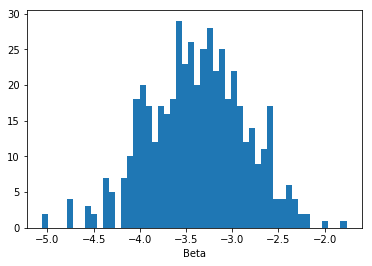

In [23]:
# Show Betas without warmups
plt.hist(samples['beta'][:500], 50)
plt.xlabel("Beta")

In [53]:
alpha, beta, sigma, ypred = samples['alpha'], samples['beta'], samples['sigma'], samples['ypred']

In [50]:
estimates = alpha + 1980 * beta

In [51]:
estimates.mean()

275.62223962738994

### What does the model predict for year 2016? Plot the histogram of the posterior predictive distribution for number of people drown at x = 2016.

For year 2016 the model predicts 156.95 people would die in average with standard error mean of 0.75.


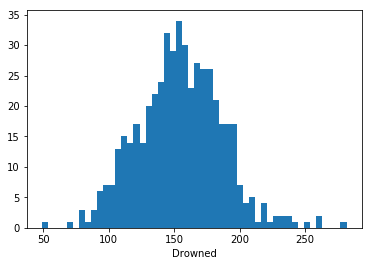

In [54]:
plt.hist(ypred[:500], 50)
plt.xlabel("Drowned")

## 2. Hierarchical model: factory data with Stan (3p)

The provided factory.txt file contains quality control measurements from 6 machines in a factory (units of the measurements are irrelevant here). Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine. In addition to the existing machines, we are interested in the quality of another machine (the seventh machine). 

Implement a 
- separate, 
- pooled and 
- hierarchical Gaussian model 
    
described in Section 11.6 using Stan. 

Similarly as in the model description in the book, __use the same measurement standard deviation σ for all the groups in the hierarchical model__. In the separate model however, __use separate measurement standard deviation $\sigma_j$ for each group j__. 

Using each of the three models – separate, pooled, and hierarchical – report (__plot histogram and comment on the results__):

In [63]:
d = np.loadtxt("data/factory.txt");d

array([[  83.,  117.,  101.,  105.,   79.,   57.],
       [  92.,  109.,   93.,  119.,   97.,   92.],
       [  92.,  114.,   92.,  116.,  103.,  104.],
       [  46.,  104.,   86.,  102.,   79.,   77.],
       [  67.,   87.,   67.,  116.,   92.,  100.]])

In [78]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 6,  # 6 machines
    x = x,  # group indicators
    y = y   # observations
)

array([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5,
       6, 1, 2, 3, 4, 5, 6])

In [79]:
#  Comparison of k groups with common variance (ANOVA)
data_code = '''
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}
'''

In [80]:
sm = pystan.StanModel(model_code=data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dabc85ba871929f691cd2c541e749fce NOW.


In [71]:
factory_model_path = 'stan_models/factory_model.pkl'

In [69]:
with open('stan_models/factory_model.pkl', 'wb') as f:
    pickle.dump(sm, f)

In [72]:
sm = pickle.load(open(factory_model_path, 'rb'))

In [81]:
fit = sm.sampling(data=data, seed=194838);fit

Inference for Stan model: anon_model_dabc85ba871929f691cd2c541e749fce.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]  75.94    0.11   6.84  62.02  71.68  76.02  80.28  89.02   4000    1.0
mu[1] 106.21    0.11   6.79  92.89 101.85 106.17 110.44 120.27   4000    1.0
mu[2]  87.83    0.11   6.92  74.37   83.3  87.89  92.23 101.49   4000    1.0
mu[3] 111.54     0.1   6.55   98.2 107.43 111.57  115.8 124.14   4000    1.0
mu[4]  89.95    0.11   6.91  76.73  85.51  89.94   94.3 103.92   4000    1.0
mu[5]  85.99    0.11   6.84  72.43  81.57  86.02  90.47 100.02   4000    1.0
sigma  15.12    0.04   2.37  11.34   13.4  14.84  16.46  20.56   4000    1.0
lp__  -92.92    0.06   2.15 -98.17 -94.07 -92.55 -91.33 -89.88   1104    1.0

Samples were drawn using NUTS at Tue Oct 31 18:00:24 2017.
For each parameter, n_eff is a crude measure of effective 

In [82]:
samples = fit.extract(permuted=True)

In [90]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


### i) the posterior distribution of the mean of the quality measurements of the sixth machine 

### ii) the predictive distribution for another quality measurement of the sixth machine

### iii) the posterior distribution of the mean of the quality measurements of the seventh machine.